In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

In [5]:
#load the data. It comes in train.h5 so we need to us HDFStore
df = pd.HDFStore("../data/train.h5", "r").get("train")

In [6]:
# I make vectors that hold the ratio of NAN values for a given id in a given column
unique_ids = pd.unique(df.id)
len(unique_ids)
NaN_vectors = np.zeros(shape=(len(unique_ids), df.shape[1]))

for i, i_id in enumerate(unique_ids):
    data_sub = df[df.id ==i_id]
    NaN_vectors[i,:] = np.sum(data_sub.isnull(),axis=0) /float(data_sub.shape[0])
    
NaN_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.09100938,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.09100938,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.28571429, ...,  0.28571429,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ]])

In [7]:
# get all the NaN vectors in which every collumn for that ID is NaN. What we are looking for 
#is collumns in which the features fundamentally do not exist. 
bin_NaN = 1*(NaN_vectors==1)
print("Still has the shape of {} by {}".format(bin_NaN.shape[0],bin_NaN.shape[1]))

Still has the shape of 1424 by 111


In [8]:
# we now have a vector of things that are either 1 where nothing exists in the column or zero something
#exists Now we take a covariance over these bins to see which ones move togehter. we are looking only based on columns
bin_cov=np.corrcoef(bin_NaN.T)
bin_cov.shape[1]

111

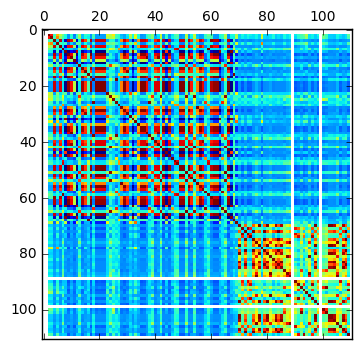

In [11]:
# plot bin_cov
plt.matshow(bin_cov)

#if you think about what this shows it is show the probability that when an entire column is missing what
# is the probability that another column will be completely missing. 

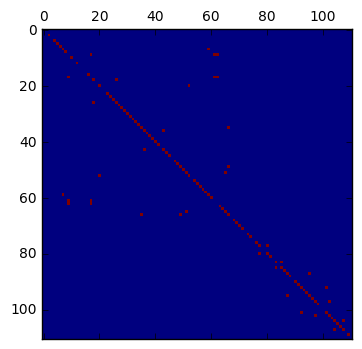

In [12]:
# In this graph i make the matrix sparse by considering only things that have perfect correlation. This
# gives us insight into the relationship of the pairs.
plt.matshow(bin_cov == 1) 

In [13]:
# What we are doing here is looking at all the column pairs that when they are missing  they are always
# missing together. ie they have a corralation of 1. We also get the count. it stands to reason that
# if this happens in only one or two id's out of 1400 then perhaps it is a statistical anomoly or could be 
# reflective of a non structural issue. This is actually very enlightening and we see there are 60
# some odd pairs that satisfy this criteria. More importantly is that it happens for lots of tickers.
# Maybe we have soemthing here.
bin_NaN
edges = []
count =np.dot(bin_NaN.T,bin_NaN)
for i in range(bin_cov.shape[0]):
    for j in range(bin_cov.shape[0]-i):
        if i!=i+j and bin_cov[i,i+j]==1:
            edges.append([i,i+j,count[i,i+j]])
print(edges)

[[7, 59, 25], [9, 17, 305], [9, 61, 305], [9, 62, 305], [17, 61, 305], [17, 62, 305], [18, 26, 76], [20, 52, 296], [35, 66, 294], [36, 43, 296], [49, 66, 294], [51, 65, 17], [77, 80, 9], [83, 85, 10], [87, 95, 4], [92, 101, 10], [97, 102, 9], [104, 107, 10]]


In [14]:
#lets see how many unique counts there are. it looks like a few of these counts happen multiple times.
# this is interesting and could imply some structural issue.
ucount = [i[2] for i in edges]
print(np.unique(ucount))

[  4   9  10  17  25  76 294 296 305]


In [15]:
print('rows: {}'.format(bin_NaN.shape[0]))
print('cols: {}'.format(len(edges)))

# the idea here is that we create a feature vector. We look at all the ids which have all their data
# missing in a certain collumn. above we found that if all the data is missing in a certain collumn it
# would be missing in another collumn as well. so we look at all these pairs (shown as edges) and we 
# then create a matrix of id x edges. We then put a 0 or a 1 in the collumn to indicate that the pair of 
# data is missing or not. This serves as a feature. I will then go on to cluster over these features. 

nan_features = np.zeros((bin_NaN.shape[0],len(edges)))
for i in range(bin_NaN.shape[0]):
    for j, edge in enumerate(edges):
        nan_features[i,j] = 1*(bin_NaN[i,edge[0]] & bin_NaN[i,edge[1]])

print('this is just a check that indexing is correct: {}'.format(np.sum(nan_features,axis=1).shape[0]))

rows: 1424
cols: 18
this is just a check that indexing is correct: 1424
